In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from skopt import plots
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import raybay

In [2]:
# Load treatment plan results
approved = np.load('approved_10/res.pkl', allow_pickle=True)
default = np.load('default_10/res.pkl', allow_pickle=True)
#res_dummy = np.load('pars/res_linear_quadratic_dummy_minimize.pkl', allow_pickle=True)
res_bayes = np.load('bayes_10/res_linear_quadratic_gp_minimize.pkl', allow_pickle=True)

In [4]:
res_bayes.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,Chestwall_L,MaxDvh,AtMost,3000,2.04
1,D2cm,MaxDose,AtMost,2400,NaN
2,Esophagus,MaxDvh,AtMost,1880,16.91
3,Lungs,MaxDvh,AtMost,1160,29.19
4,Lungs,MaxDvh,AtMost,1240,19.46
5,PTV,MinDvh,AtLeast,4800,95.00
6,PTV,MaxDose,AtMost,8000,NaN
7,Rib,MaxDvh,AtMost,3200,0.27
8,Rib,MaxDose,AtMost,4000,NaN
9,SpinalCanal,MaxDvh,AtMost,1360,2.30


In [5]:
res_bayes.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,Chestwall_L,MaxDvh,3000,2.04,NaN,1
1,D2cm,MaxDose,"[0,2400]",0.00,NaN,1
2,Esophagus,MaxDvh,1880,16.91,NaN,1
3,Lungs,MaxDvh,1160,29.19,NaN,1
4,Lungs,MaxDvh,1240,19.46,NaN,1
5,PTV,MinDvh,4800,95.00,NaN,1
6,PTV,MaxDose,8000,0.00,NaN,1
7,Rib,MaxDvh,3200,0.27,NaN,1
8,Rib,MaxDose,"[0,4000]",0.00,NaN,1
9,SpinalCanal,MaxDvh,1360,2.30,NaN,1


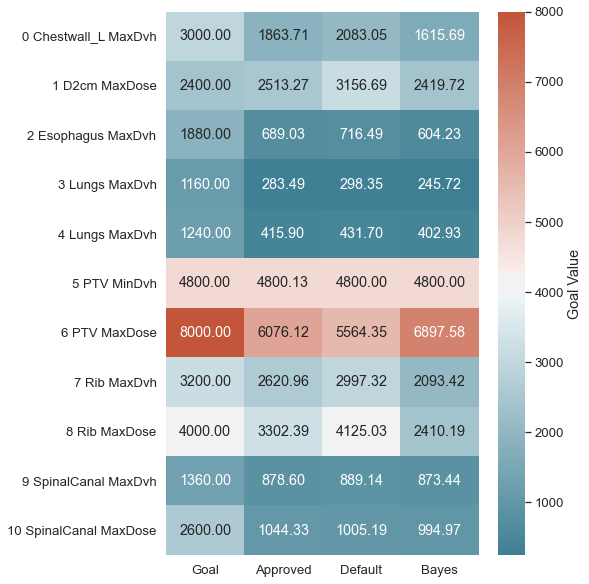

In [9]:
# Compare goal values
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
#idx_dummy = np.argmin(res_dummy.opt_result.func_vals)
idx_bayes = np.argmin(res_bayes.opt_result.func_vals)
X = np.zeros((len(approved.goal_df),4)) # 5
for index, row in approved.goal_df.iterrows():
    X[index, 0] = row['AcceptanceLevel']
    X[index, 1] = approved.goal_dict[index][0]
    X[index, 2] = default.goal_dict[index][0]
    #X[index, 3] = res_dummy.goal_dict[index][idx_dummy]
    X[index, 3] = res_bayes.goal_dict[index][idx_bayes]
Y = pd.DataFrame(columns=['Goal', 'Approved', 'Default', 'Bayes'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(7, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Goal Value'},
            fmt=".2f");

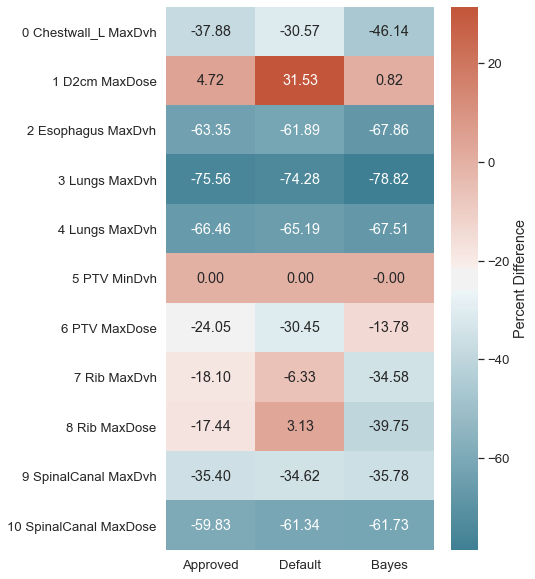

In [10]:
# Compare goal percent difference
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
X = np.zeros((len(approved.goal_df),3)) # 4
for index, row in approved.goal_df.iterrows():
    X[index, 0] = -raybay.get_term(approved.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 1] = -raybay.get_term(default.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    #X[index, 2] = -raybay.get_term(res_dummy.goal_dict[index][idx_dummy], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 2] = -raybay.get_term(res_bayes.goal_dict[index][idx_bayes], row['AcceptanceLevel'], 'Max', 'linear')
Y = pd.DataFrame(columns=['Approved', 'Default', 'Bayes'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(6, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Percent Difference'},
            fmt='.2f');

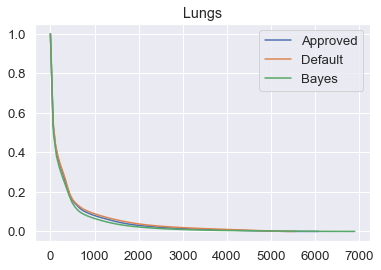

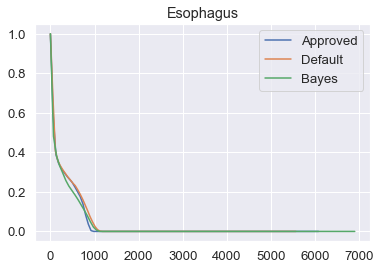

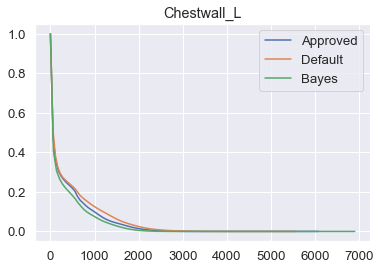

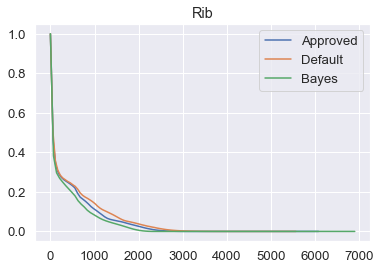

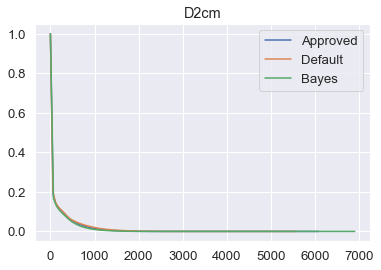

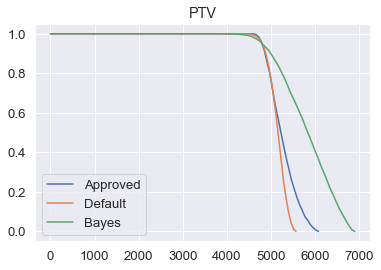

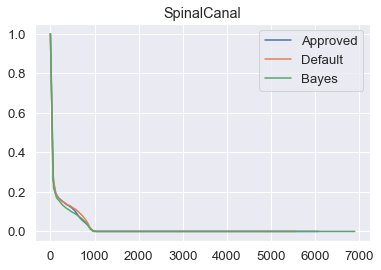

In [11]:
for roi in approved.roi_list:
    plt.figure()
    plt.plot(approved.dvh_dict['Dose'], approved.dvh_dict[roi])
    plt.plot(default.dvh_dict['Dose'], default.dvh_dict[roi])
    #plt.plot(res_dummy.dvh_dict['Dose'], res_dummy.dvh_dict[roi])
    plt.plot(res_bayes.dvh_dict['Dose'], res_bayes.dvh_dict[roi])
    plt.title(roi)
    plt.legend(['Approved', 'Default', 'Bayes'])

<IPython.core.display.Javascript object>


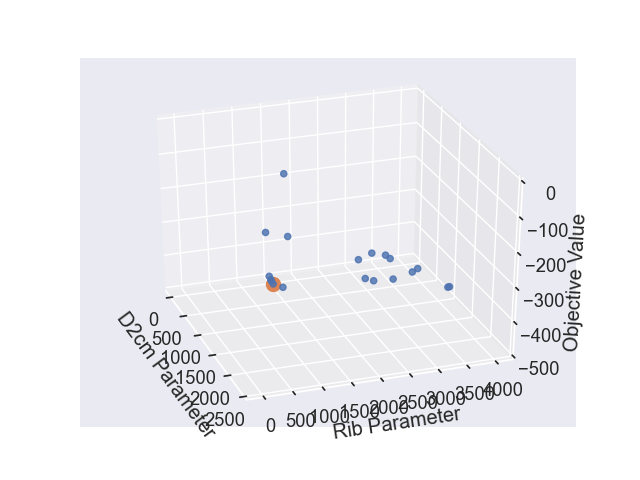

In [16]:
# Parameters vs. Objective
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
#              [row[1] for row in res_dummy.opt_result.x_iters], 
#              res_dummy.opt_result.func_vals)
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.opt_result.func_vals)
# ax.scatter3D(res_dummy.opt_result.x_iters[idx_dummy][0],
#              res_dummy.opt_result.x_iters[idx_dummy][1], res_dummy.opt_result.fun, s=100)
ax.scatter3D(res_bayes.opt_result.x_iters[idx_bayes][0],
             res_bayes.opt_result.x_iters[idx_bayes][1], res_bayes.opt_result.fun, s=100)
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Objective Value')
ax.set_zlim([-500, 0]);

<IPython.core.display.Javascript object>


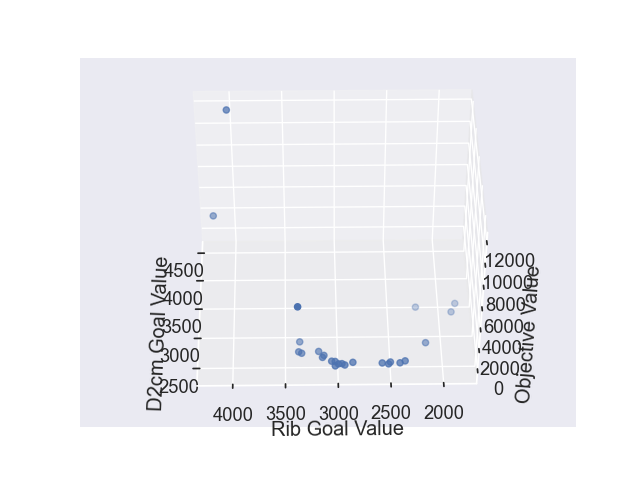

Text(0.5, 0, 'Objective Value')

In [18]:
# Parameters vs. Objective
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(res_dummy.goal_dict[3], res_dummy.goal_dict[18], 
#              res_dummy.opt_result.func_vals)
ax.scatter3D(res_bayes.goal_dict[1], res_bayes.goal_dict[8], 
             res_bayes.opt_result.func_vals)
ax.set_xlabel('D2cm Goal Value')
ax.set_ylabel('Rib Goal Value')
ax.set_zlabel('Objective Value')

Similar observations to utility vs. parameters.

<IPython.core.display.Javascript object>


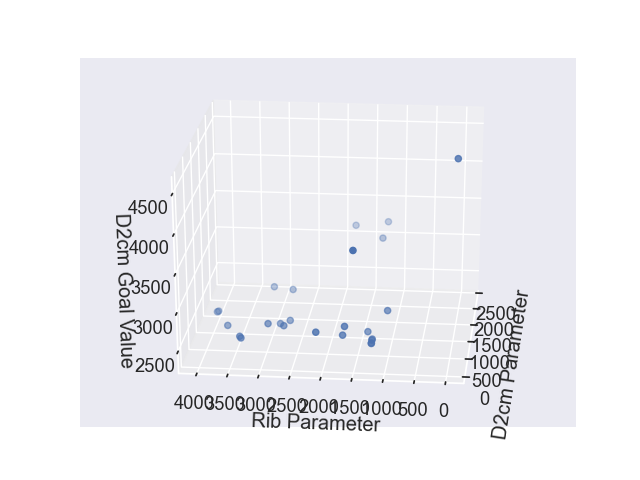

Text(0.5, 0, 'D2cm Goal Value')

In [19]:
# Parameters vs. D2cm Goal
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
#              [row[1] for row in res_dummy.opt_result.x_iters], 
#              res_dummy.goal_dict[3])
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.goal_dict[1])
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('D2cm Goal Value')

<IPython.core.display.Javascript object>


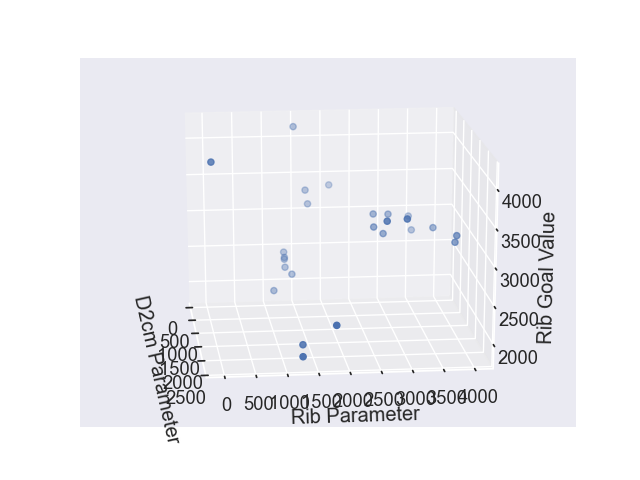

Text(0.5, 0, 'Rib Goal Value')

In [20]:
# Parameters vs. Rib Goal
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
#              [row[1] for row in res_dummy.opt_result.x_iters], 
#              res_dummy.goal_dict[18])
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.goal_dict[8])
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Rib Goal Value')

<IPython.core.display.Javascript object>


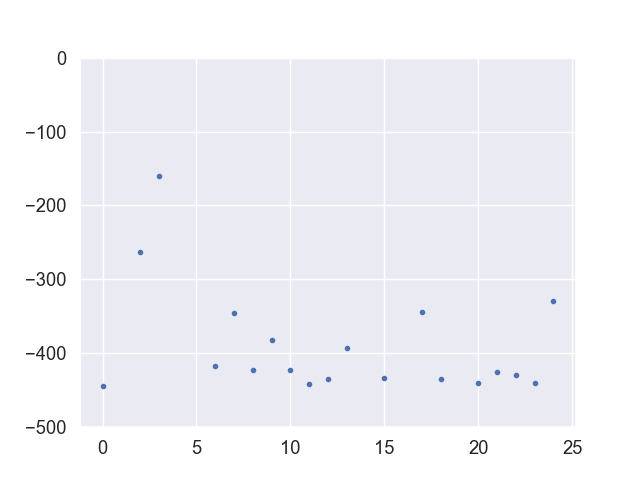

(-500.0, 0.0)

In [27]:
plt.plot(res_bayes.opt_result.func_vals, '.')
plt.ylim([-500, 0])

In [24]:
res_bays

NameError: name 'res_bays' is not defined